In [ ]:
# prompt: import drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load the dataset
file_path = '/content/drive/MyDrive/Dataset/Uber/My Uber Drives - 2016.csv'
data = pd.read_csv(file_path)

In [ ]:
# Display initial data
print("Initial Data Info:")
print(data.info())
print(data.head())

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   START_DATE*  1156 non-null   object 
 1   END_DATE*    1155 non-null   object 
 2   CATEGORY*    1155 non-null   object 
 3   START*       1155 non-null   object 
 4   STOP*        1155 non-null   object 
 5   MILES*       1156 non-null   float64
 6   PURPOSE*     653 non-null    object 
dtypes: float64(1), object(6)
memory usage: 63.3+ KB
None
      START_DATE*       END_DATE* CATEGORY*       START*            STOP*  \
0  1/1/2016 21:11  1/1/2016 21:17  Business  Fort Pierce      Fort Pierce   
1   1/2/2016 1:25   1/2/2016 1:37  Business  Fort Pierce      Fort Pierce   
2  1/2/2016 20:25  1/2/2016 20:38  Business  Fort Pierce      Fort Pierce   
3  1/5/2016 17:31  1/5/2016 17:45  Business  Fort Pierce      Fort Pierce   
4  1/6/2016 14:42  1/6/2016 15:49  Business  Fort Pier

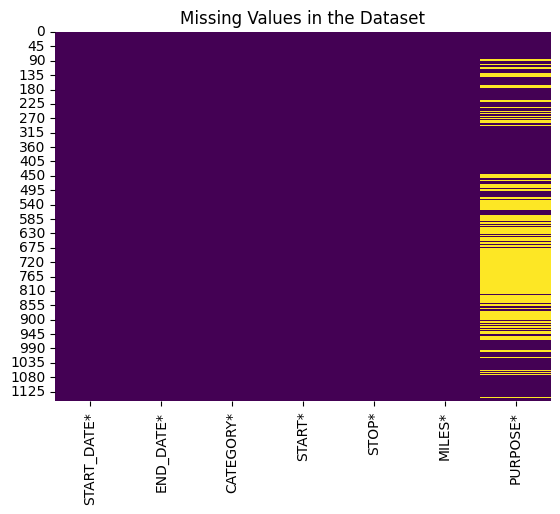

In [ ]:
# Visualize missing values
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in the Dataset')
plt.show()

In [ ]:
# Convert date columns to datetime objects
data['START_DATE*'] = pd.to_datetime(data['START_DATE*'], errors='coerce')
data['END_DATE*'] = pd.to_datetime(data['END_DATE*'], errors='coerce')

In [ ]:
# Impute missing END_DATE* based on START_DATE* and the median trip duration
median_trip_duration = (data['END_DATE*'] - data['START_DATE*']).median()
data['END_DATE*'] = data['END_DATE*'].fillna(data['START_DATE*'] + median_trip_duration)


In [ ]:
# Check missing values after date imputation
print("Missing values after date imputation:")
print(data.isnull().sum())

Missing values after date imputation:
START_DATE*      1
END_DATE*        1
CATEGORY*        1
START*           1
STOP*            1
MILES*           0
PURPOSE*       503
dtype: int64


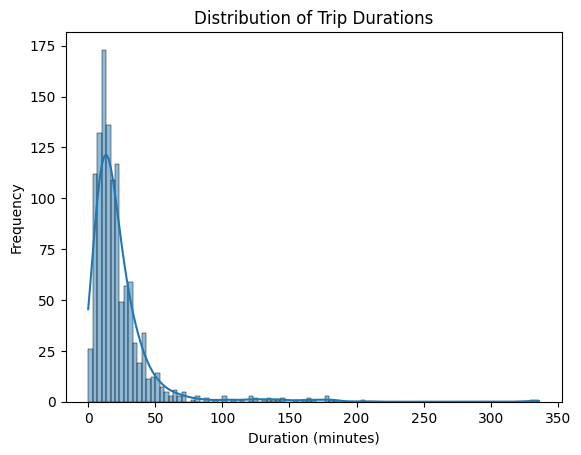

In [ ]:
# Visualize the distribution of trip durations
data['trip_duration'] = (data['END_DATE*'] - data['START_DATE*']).dt.total_seconds() / 60
sns.histplot(data['trip_duration'], kde=True)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Fill missing values for categorical columns with the most frequent value
imputer_cat = SimpleImputer(strategy='most_frequent')
data[['CATEGORY*', 'START*', 'STOP*']] = imputer_cat.fit_transform(data[['CATEGORY*', 'START*', 'STOP*']])

In [ ]:
# Check missing values after categorical imputation
print("Missing values after categorical imputation:")
print(data.isnull().sum())

Missing values after categorical imputation:
START_DATE*        1
END_DATE*          1
CATEGORY*          0
START*             0
STOP*              0
MILES*             0
PURPOSE*         503
trip_duration      1
dtype: int64


In [ ]:
# Encode categorical variables for model training
data_encoded = pd.get_dummies(data[['CATEGORY*', 'START*', 'STOP*', 'MILES*']], drop_first=True)
known_purpose = data_encoded[data['PURPOSE*'].notna()]
unknown_purpose = data_encoded[data['PURPOSE*'].isna()]

In [ ]:
# Train the Random Forest model for PURPOSE* imputation
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(known_purpose, data.loc[data['PURPOSE*'].notna(), 'PURPOSE*'])

RandomForestClassifier(random_state=42)

In [ ]:
# Predict the missing PURPOSE*
data.loc[data['PURPOSE*'].isna(), 'PURPOSE*'] = clf.predict(unknown_purpose)

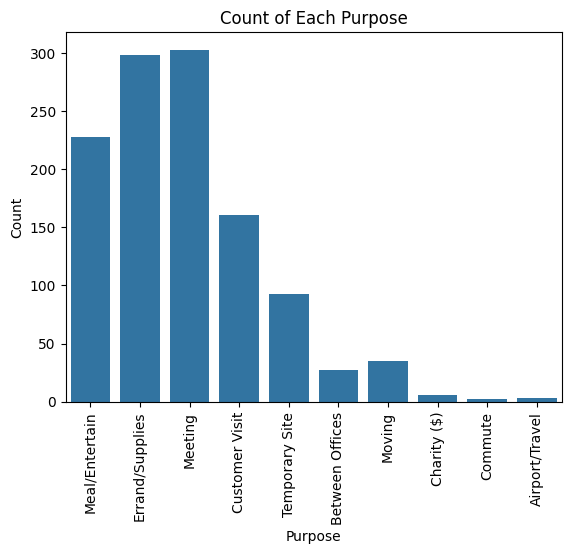

In [ ]:
# Visualize the count of each purpose
sns.countplot(x='PURPOSE*', data=data)
plt.title('Count of Each Purpose')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Detect and handle outliers in MILES*
q1 = data['MILES*'].quantile(0.25)
q3 = data['MILES*'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

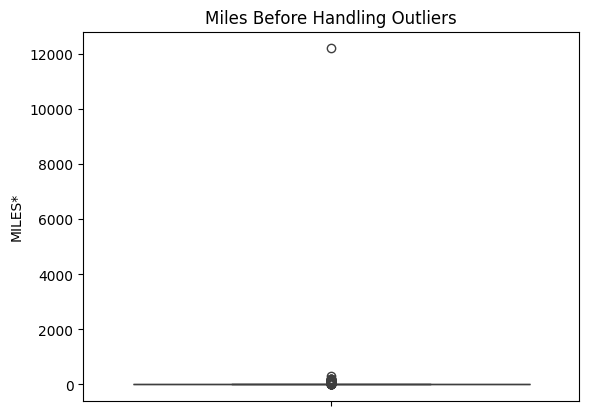

In [ ]:
# Visualize miles before handling outliers
sns.boxplot(data['MILES*'])
plt.title('Miles Before Handling Outliers')
plt.show()

In [ ]:
# Cap the outliers
data['MILES*'] = np.where(data['MILES*'] < lower_bound, lower_bound, data['MILES*'])
data['MILES*'] = np.where(data['MILES*'] > upper_bound, upper_bound, data['MILES*'])

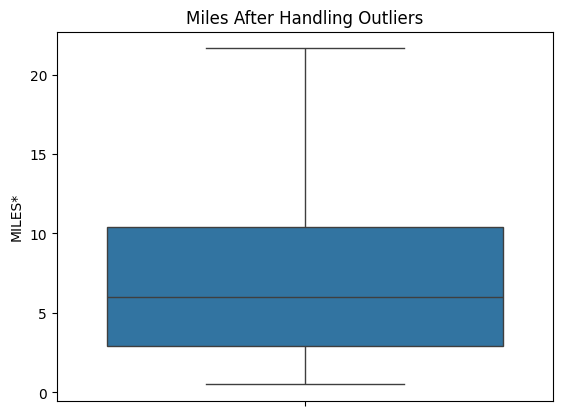

In [ ]:
# Visualize miles after handling outliers
sns.boxplot(data['MILES*'])
plt.title('Miles After Handling Outliers')
plt.show()

In [ ]:
# Verify the changes
print("Cleaned Data Info:")
print(data.info())
print(data.head())

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   START_DATE*    1155 non-null   datetime64[ns]
 1   END_DATE*      1155 non-null   datetime64[ns]
 2   CATEGORY*      1156 non-null   object        
 3   START*         1156 non-null   object        
 4   STOP*          1156 non-null   object        
 5   MILES*         1156 non-null   float64       
 6   PURPOSE*       1156 non-null   object        
 7   trip_duration  1155 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 72.4+ KB
None
          START_DATE*           END_DATE* CATEGORY*       START*  \
0 2016-01-01 21:11:00 2016-01-01 21:17:00  Business  Fort Pierce   
1 2016-01-02 01:25:00 2016-01-02 01:37:00  Business  Fort Pierce   
2 2016-01-02 20:25:00 2016-01-02 20:38:00  Business  Fort Pierce   
3 2016-01-05 17:

In [ ]:
# Save the cleaned data to a new CSV file
cleaned_file_path = 'cleaned_EVLNxZ.csv'
data.to_csv(cleaned_file_path, index=False)

In [ ]:
# Code for downloading the cleaned file (specific to Google Colab)
from google.colab import files
files.download(cleaned_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Calculate the average length of the trip
average_trip_length = data['trip_duration'].mean()
print(f"Average length of the trip: {average_trip_length:.2f} minutes")

Average length of the trip: 23.24 minutes


In [ ]:
# Calculate the average number of rides per week and per month
data['week'] = data['START_DATE*'].dt.isocalendar().week
data['month'] = data['START_DATE*'].dt.month
average_rides_per_week = data.groupby('week').size().mean()
average_rides_per_month = data.groupby('month').size().mean()
print(f"Average number of rides per week: {average_rides_per_week:.2f}")
print(f"Average number of rides per month: {average_rides_per_month:.2f}")

Average number of rides per week: 21.79
Average number of rides per month: 96.25


In [ ]:
# Visualize the number of rides per week and per month

Text(0, 0.5, 'Number of Rides')

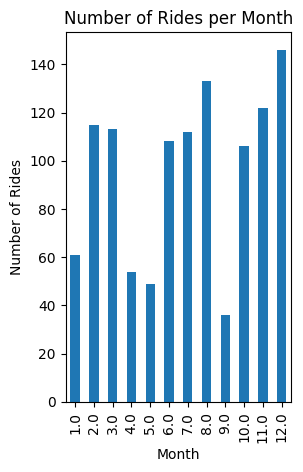

In [ ]:
plt.subplot(1, 2, 2)
data['month'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Rides per Month')
plt.xlabel('Month')
plt.ylabel('Number of Rides')

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate total tax savings based on traveled business miles
# Assume tax savings of $0.50 per business mile (example value)
business_miles = data.loc[data['CATEGORY*'] == 'Business', 'MILES*'].sum()
tax_savings = business_miles * 0.50
print(f"Total tax savings based on traveled business miles: ${tax_savings:.2f}")

Total tax savings based on traveled business miles: $4144.20


In [ ]:
# Calculate the percentage of business miles vs personal vs meals
total_miles = data['MILES*'].sum()
business_miles = data.loc[data['CATEGORY*'] == 'Business', 'MILES*'].sum()
personal_miles = data.loc[data['CATEGORY*'] == 'Personal', 'MILES*'].sum()
meals_miles = data.loc[data['PURPOSE*'] == 'Meal/Entertain', 'MILES*'].sum()

business_percentage = (business_miles / total_miles) * 100
personal_percentage = (personal_miles / total_miles) * 100
meals_percentage = (meals_miles / total_miles) * 100

print(f"Percentage of business miles: {business_percentage:.2f}%")
print(f"Percentage of personal miles: {personal_percentage:.2f}%")
print(f"Percentage of meals miles: {meals_percentage:.2f}%")

Percentage of business miles: 94.12%
Percentage of personal miles: 5.88%
Percentage of meals miles: 13.77%


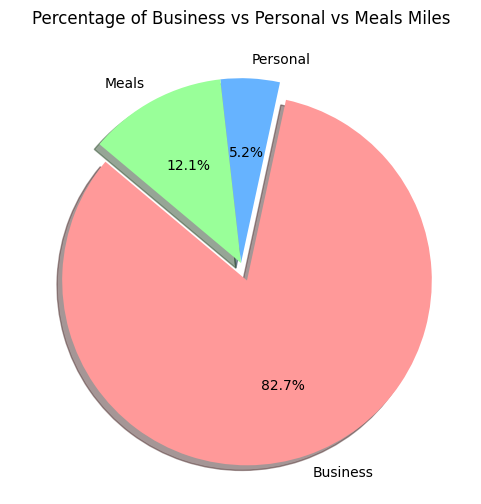

In [ ]:
# Visualize the percentage of business miles vs personal vs meals
labels = ['Business', 'Personal', 'Meals']
sizes = [business_percentage, personal_percentage, meals_percentage]
colors = ['#ff9999','#66b3ff','#99ff99']
explode = (0.1, 0, 0)  # explode the first slice

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage of Business vs Personal vs Meals Miles')
plt.show()

In [ ]:
# Estimate money saved by using Uber, Careem, or Lyft vs regular cab service
# Assume average cost per mile for Uber, Careem, Lyft: $1.50
# Assume average cost per mile for regular cab: $2.50

total_miles_traveled = data['MILES*'].sum()
uber_cost = total_miles_traveled * 1.50
cab_cost = total_miles_traveled * 2.50
money_saved = cab_cost - uber_cost

print(f"Money saved by using Uber, Careem, or Lyft versus regular cab service: ${money_saved:.2f}")

Money saved by using Uber, Careem, or Lyft versus regular cab service: $8806.50


In [ ]:
# Visualize the cost comparison
costs = [uber_cost, cab_cost]
labels = ['Uber/Careem/Lyft', 'Regular Cab']
colors = ['#ff9999', '#66b3ff']

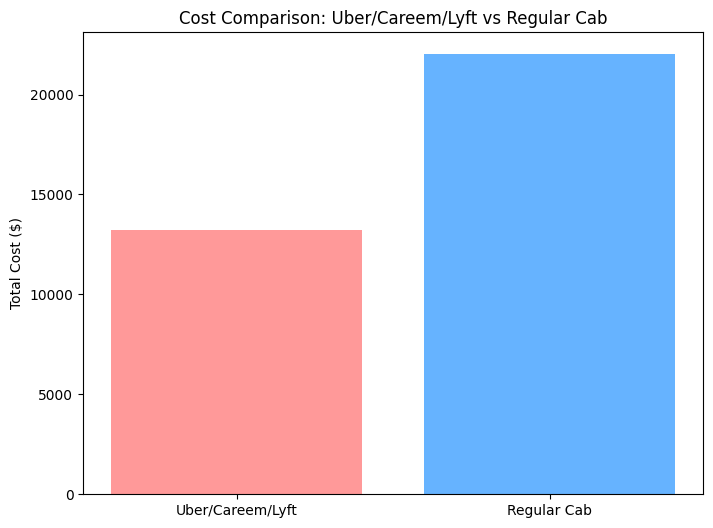

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(labels, costs, color=colors)
plt.title('Cost Comparison: Uber/Careem/Lyft vs Regular Cab')
plt.ylabel('Total Cost ($)')
plt.show()